In [3]:
import RNA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
from Bio.Seq import Seq
from Bio import motifs
import random

import keras
np.random.seed(1337)

from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D

%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'


def train_model(x, y, border_mode='same', inp_len=50, nodes=40, layers=3, filter_len=8, nbr_filters=120,
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    ''' Build model archicture and fit.'''
    model = Sequential()
    if layers >= 1:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    if layers >= 2:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)

    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1)
    return model


def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))   #LAE: .values added, pd deprecation
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq]).flatten
        vectors[i] = a
    return vectors


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

Using TensorFlow backend.


### Load data, make a train and test set based on total reads per UTR
The test set contains UTRs with the highest overall sequencing reads with the idea that increased reads will more accurately reflect the true ribosome load of a given 5'UTR.

In [4]:
#df = pd.read_pickle('../data/egfp_unmod_1.pkl')  #LAE: do not have this pickle file...?
df = pd.read_csv('../data/egfp_unmod_1.csv')
df.sort_values('total_reads', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:280000]

# The training set has 260k UTRs and the test set has 20k UTRs.
e_test = df.iloc[:20000]
e_train = df.iloc[20000:]

# One-hot encode both training and test UTRs
seq_e_train = one_hot_encode(e_train,seq_len=50)
seq_e_test = one_hot_encode(e_test, seq_len=50)

# Scale the training mean ribosome load values
# LAE: added .values before reshape due to pandas naming deprecation
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Train model
Using the author's parameters, but vary in the number of filters, number of layers, and increase the filter length to greater than the 12 they tried in order to try and capture long-range interactions

In [5]:
# Load Models
model_16bp = keras.models.load_model('./saved_models/120f16bp_cnn.hdf5')
model_20bp = keras.models.load_model('./saved_models/120f20bp_cnn.hdf5')
model_21bp = keras.models.load_model('./saved_models/120f21bp_cnn.hdf5')
model_25bp = keras.models.load_model('./saved_models/120f25bp_cnn.hdf5')
small_model_16bp = keras.models.load_model('./saved_models/10f16bp_cnn.hdf5')
small_model_20bp = keras.models.load_model('./saved_models/10f20bp_cnn.hdf5')
small_model_25bp = keras.models.load_model('./saved_models/10f25bp_cnn.hdf5')
small_model_35bp = keras.models.load_model('./saved_models/10f35bp_cnn.hdf5')
small_model_50bp = keras.models.load_model('./saved_models/10f50bp_cnn.hdf5')

W0910 11:17:14.204097 4652062144 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0910 11:17:14.261858 4652062144 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0910 11:17:14.361350 4652062144 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0910 11:17:14.362737 4652062144 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0910 11:17:14.374911 4652062144 deprecat

In [6]:
# np.random.seed(1337)
# model_3bp = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=3,border_mode='same',
#                     inp_len=50, nodes=40, layers=3, nbr_filters=120, filter_len=3, dropout1=0,
#                     dropout2=0,dropout3=0.2)

Epoch 1/3
260000/260000 [==============================] - 95s 364us/step - loss: 0.2714
Epoch 2/3
260000/260000 [==============================] - 99s 379us/step - loss: 0.1910
Epoch 3/3
260000/260000 [==============================] - 86s 331us/step - loss: 0.1776


In [7]:
e_test = test_data(df=e_test, model=model_3bp, obs_col='rl',test_seq=seq_e_test,output_col='3bp_pred')
r = r2(e_test['rl'], e_test['3bp_pred'])
print 'r-squared = ', r

r-squared =  0.9106679768917627


In [8]:
# np.random.seed(1337)
# model_6bp = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=3,border_mode='same',
#                     inp_len=50, nodes=40, layers=3, nbr_filters=120, filter_len=6, dropout1=0,
#                     dropout2=0,dropout3=0.2)

Epoch 1/3
260000/260000 [==============================] - 144s 554us/step - loss: 0.2487
Epoch 2/3
260000/260000 [==============================] - 145s 557us/step - loss: 0.1666
Epoch 3/3
260000/260000 [==============================] - 165s 636us/step - loss: 0.1563


In [9]:
e_test = test_data(df=e_test, model=model_6bp, obs_col='rl',test_seq=seq_e_test,output_col='6bp_pred')
r = r2(e_test['rl'], e_test['6bp_pred'])
print 'r-squared = ', r

r-squared =  0.9269160431035783


In [5]:
# np.random.seed(1337)
# model_16bp = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=3,border_mode='same',
#                     inp_len=50, nodes=40, layers=3, nbr_filters=120, filter_len=16, dropout1=0,
#                     dropout2=0,dropout3=0.2)

Epoch 1/3
260000/260000 [==============================] - 2881s 11ms/step - loss: 0.3038
Epoch 2/3
260000/260000 [==============================] - 603s 2ms/step - loss: 0.1682
Epoch 3/3
260000/260000 [==============================] - 373s 1ms/step - loss: 0.1580


In [6]:
e_test = test_data(df=e_test, model=model_16bp, obs_col='rl',test_seq=seq_e_test,output_col='16bp_pred')
r = r2(e_test['rl'], e_test['16bp_pred'])
print 'r-squared = ', r 
print 'r-squared of original model = 0.9338...'

r-squared =  0.925517310100416
r-squared of original model = 0.9338...


In [12]:
# np.random.seed(1337)
# model_20bp = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=3,border_mode='same',
#                     inp_len=50, nodes=40, layers=3, nbr_filters=120, filter_len=20, dropout1=0,
#                     dropout2=0,dropout3=0.2)

Epoch 1/3
260000/260000 [==============================] - 447s 2ms/step - loss: 0.2850
Epoch 2/3
260000/260000 [==============================] - 466s 2ms/step - loss: 0.1384
Epoch 3/3
260000/260000 [==============================] - 485s 2ms/step - loss: 0.1282


In [13]:
e_test = test_data(df=e_test, model=model_20bp, obs_col='rl',test_seq=seq_e_test,output_col='20bp_pred')
r = r2(e_test['rl'], e_test['20bp_pred'])
print 'r-squared = ', r

r-squared =  0.937449380938982


In [28]:
# np.random.seed(1337)
# model_21bp = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=3,border_mode='same',
#                     inp_len=50, nodes=40, layers=3, nbr_filters=120, filter_len=21, dropout1=0,
#                     dropout2=0,dropout3=0.2)

Epoch 1/3
260000/260000 [==============================] - 504s 2ms/step - loss: 0.2994
Epoch 2/3
260000/260000 [==============================] - 478s 2ms/step - loss: 0.1434
Epoch 3/3
260000/260000 [==============================] - 497s 2ms/step - loss: 0.1325


In [29]:
e_test = test_data(df=e_test, model=model_21bp, obs_col='rl',test_seq=seq_e_test,output_col='21bp_pred')
r = r2(e_test['rl'], e_test['21bp_pred'])
print 'r-squared = ', r 

r-squared =  0.9340513884971967


In [24]:
# np.random.seed(1337)
# model_25bp = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=3,border_mode='same',
#                     inp_len=50, nodes=40, layers=3, nbr_filters=120, filter_len=25, dropout1=0,
#                     dropout2=0,dropout3=0.2)

Epoch 1/3
260000/260000 [==============================] - 601s 2ms/step - loss: 1.0053
Epoch 2/3
260000/260000 [==============================] - 566s 2ms/step - loss: 1.0001
Epoch 3/3
260000/260000 [==============================] - 719s 3ms/step - loss: 1.0000


WHY IS THIS TRASH AT PREDICTING WHEN 21BP IS FINE??

### How important is the size of the model? 
Does reducing its size only lose a small amount of r-squared, like with the 8-bp window CNN? That might seem to indicate that the total information content available is limited, but maybe that's not the correct interpretation...?

In [25]:
e_test = test_data(df=e_test, model=model_25bp, obs_col='rl',test_seq=seq_e_test,output_col='25bp_pred')
r = r2(e_test['rl'], e_test['25bp_pred'])
print 'r-squared = ', r 
# starts out with crazy high loss, like 1.5 rather than the usual 1.0 -- what is that about?

r-squared =  0.0


In [14]:
# np.random.seed(1337)
# small_model_16bp = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=3,border_mode='same',
#                     inp_len=50, nodes=40, layers=3, nbr_filters=10, filter_len=16, dropout1=0,
#                     dropout2=0,dropout3=0.2)

Epoch 1/3
260000/260000 [==============================] - 28s 107us/step - loss: 0.3850
Epoch 2/3
260000/260000 [==============================] - 23s 88us/step - loss: 0.1994
Epoch 3/3
260000/260000 [==============================] - 24s 91us/step - loss: 0.1664


In [15]:
e_test = test_data(df=e_test, model=small_model_16bp, obs_col='rl',test_seq=seq_e_test,output_col='10f16bp_pred')
r = r2(e_test['rl'], e_test['10f16bp_pred'])
print 'r-squared = ', r 

r-squared =  0.9169529718608588


In [16]:
# np.random.seed(1337)
# small_model_20bp = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=3,border_mode='same',
#                     inp_len=50, nodes=40, layers=3, nbr_filters=10, filter_len=20, dropout1=0,
#                     dropout2=0,dropout3=0.2)

Epoch 1/3
260000/260000 [==============================] - 26s 101us/step - loss: 0.4175
Epoch 2/3
260000/260000 [==============================] - 26s 100us/step - loss: 0.2120
Epoch 3/3
260000/260000 [==============================] - 26s 99us/step - loss: 0.1711


In [17]:
e_test = test_data(df=e_test, model=small_model_20bp, obs_col='rl',test_seq=seq_e_test,output_col='10f20bp_pred')
r = r2(e_test['rl'], e_test['10f20bp_pred'])
print 'r-squared = ', r 

r-squared =  0.9115283527581858


In [18]:
# np.random.seed(1337)
# small_model_25bp = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=3,border_mode='same',
#                     inp_len=50, nodes=40, layers=3, nbr_filters=10, filter_len=25, dropout1=0,
#                     dropout2=0,dropout3=0.2)

Epoch 1/3
260000/260000 [==============================] - 30s 114us/step - loss: 0.4002
Epoch 2/3
260000/260000 [==============================] - 29s 111us/step - loss: 0.1706
Epoch 3/3
260000/260000 [==============================] - 28s 108us/step - loss: 0.1453


In [19]:
e_test = test_data(df=e_test, model=small_model_25bp, obs_col='rl',test_seq=seq_e_test,output_col='10f25bp_pred')
r = r2(e_test['rl'], e_test['10f25bp_pred'])
print 'r-squared = ', r 

r-squared =  0.9261690537255599


In [20]:
# np.random.seed(1337)
# small_model_35bp = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=3,border_mode='same',
#                     inp_len=50, nodes=40, layers=3, nbr_filters=10, filter_len=35, dropout1=0,
#                     dropout2=0,dropout3=0.2)

Epoch 1/3
260000/260000 [==============================] - 42s 161us/step - loss: 0.4234
Epoch 2/3
260000/260000 [==============================] - 42s 160us/step - loss: 0.1701
Epoch 3/3
260000/260000 [==============================] - 46s 176us/step - loss: 0.1440


In [21]:
e_test = test_data(df=e_test, model=small_model_35bp, obs_col='rl',test_seq=seq_e_test,output_col='10f35bp_pred')
r = r2(e_test['rl'], e_test['10f35bp_pred'])
print 'r-squared = ', r 

r-squared =  0.9272252830028022


In [22]:
# np.random.seed(1337)
# small_model_50bp = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=3,border_mode='same',
#                     inp_len=50, nodes=40, layers=3, nbr_filters=10, filter_len=50, dropout1=0,
#                     dropout2=0,dropout3=0.2)

Epoch 1/3
260000/260000 [==============================] - 56s 215us/step - loss: 0.4048
Epoch 2/3
260000/260000 [==============================] - 53s 206us/step - loss: 0.1705
Epoch 3/3
260000/260000 [==============================] - 54s 206us/step - loss: 0.1497


In [23]:
e_test = test_data(df=e_test, model=small_model_50bp, obs_col='rl',test_seq=seq_e_test,output_col='10f50bp_pred')
r = r2(e_test['rl'], e_test['10f50bp_pred'])
print 'r-squared = ', r 

r-squared =  0.921803422775107


In [10]:
# Save Models
model_3bp.save('./saved_models/120f3bp_cnn.hdf5')
model_6bp.save('./saved_models/120f6bp_cnn.hdf5')
# model_16bp.save('./saved_models/120f16bp_cnn.hdf5')
# model_20bp.save('./saved_models/120f20bp_cnn.hdf5')
# model_21bp.save('./saved_models/120f21bp_cnn.hdf5')
# model_25bp.save('./saved_models/120f25bp_cnn.hdf5')
# small_model_16bp.save('./saved_models/10f16bp_cnn.hdf5')
# small_model_20bp.save('./saved_models/10f20bp_cnn.hdf5')
# small_model_25bp.save('./saved_models/10f25bp_cnn.hdf5')
# small_model_35bp.save('./saved_models/10f35bp_cnn.hdf5')
# small_model_50bp.save('./saved_models/10f50bp_cnn.hdf5')

## Visualizing Model Results

In [21]:
# Evaluate Performance on Train Dataset, Large Models
# 3 bp 
e_train = test_data(df=e_train, model=model_3bp, obs_col='rl', test_seq=seq_e_train,output_col='3bp_pred')
r = r2(e_train['rl'], e_train['3bp_pred'])
print '3bp r-squared = ', r
# 6 bp
e_train = test_data(df=e_train, model=model_6bp, obs_col='rl', test_seq=seq_e_train,output_col='6bp_pred')
r = r2(e_train['rl'], e_train['6bp_pred'])
print '6bp r-squared = ', r
# 16 bp
e_train = test_data(df=e_train, model=model_16bp, obs_col='rl', test_seq=seq_e_train,output_col='16bp_pred')
r = r2(e_train['rl'], e_train['16bp_pred'])
print '16bp r-squared = ', r
# 20 bp
e_train = test_data(df=e_train, model=model_20bp, obs_col='rl', test_seq=seq_e_train,output_col='20bp_pred')
r = r2(e_train['rl'], e_train['20bp_pred'])
print '20bp r-squared = ', r
# 21 bp
e_train = test_data(df=e_train, model=model_21bp, obs_col='rl', test_seq=seq_e_train,output_col='21bp_pred')
r = r2(e_train['rl'], e_train['21bp_pred'])
print '21bp r-squared = ', r

3bp r-squared =  0.8708604148213536
6bp r-squared =  0.8892251695327803
16bp r-squared =  0.8921937996936078
20bp r-squared =  0.9011482216546154


NameError: name 'model_21bp' is not defined

In [26]:
# Evaluate Performance on Train Dataset, Small Models
# 10-filter 16bp
e_train = test_data(df=e_train, model=small_model_16bp, obs_col='rl', test_seq=seq_e_train,output_col='10f16bp_pred')
r = r2(e_train['rl'], e_train['10f16bp_pred'])
print '10-filter 16bp r-squared = ', r
# 10-filter 20bp
e_train = test_data(df=e_train, model=small_model_20bp, obs_col='rl', test_seq=seq_e_train,output_col='10f20bp_pred')
r = r2(e_train['rl'], e_train['10f20bp_pred'])
print '10-filter 20bp r-squared = ', r
# 10-filter 25bp
e_train = test_data(df=e_train, model=small_model_25bp, obs_col='rl', test_seq=seq_e_train,output_col='10f25bp_pred')
r = r2(e_train['rl'], e_train['10f25bp_pred'])
print '10-filter 25bp r-squared = ', r
# 10-filter 35bp
e_train = test_data(df=e_train, model=small_model_35bp, obs_col='rl', test_seq=seq_e_train,output_col='10f35bp_pred')
r = r2(e_train['rl'], e_train['10f35bp_pred'])
print '10-filter 35bp r-squared = ', r
# 10-filter 50bp
e_train = test_data(df=e_train, model=small_model_50bp, obs_col='rl', test_seq=seq_e_train,output_col='10f50bp_pred')
r = r2(e_train['rl'], e_train['10f50bp_pred'])
print '10-filter 50bp r-squared = ', r

10-filter 16bp r-squared =  0.8696483755512039
10-filter 20bp r-squared =  0.8617971323292124
10-filter 25bp r-squared =  0.8788361197440304
10-filter 35bp r-squared =  0.878556529017891
10-filter 50bp r-squared =  0.8727581738931063


In [23]:
# Make Function for Reuseability
def jointgrid_plot(datasets,one_dataset=False,colors=[(0.3, 0.45, 0.69),'r'],title="",alphas=[0.1,0.1],
                   xheader='rl',yheader='pred'):
    """
    Make a jointgrid scatter plot of Observed MRL vs Predicted MRL using two or more different datasets 
    colored according to the input list of colors, in a style like the author's figure. 
    If only one dataset, set the flag one_dataset to True so that datasets can be of type list without 
    getting datasets vs dataset elements confused. Bad code but hey.
    """
    data = datasets if one_dataset == True else datasets[0]
    
    g = sns.JointGrid(x=xheader, y=yheader, data=data, space=0, xlim=(1,10), ylim=(0,10), ratio=6, size=7)
    g.plot_joint(plt.scatter,s=20, color=colors[0], linewidth=0.2, alpha=str(alphas[0]), edgecolor='white')
    f = g.fig
    ax = f.gca()
    ax.set_yticks(np.arange(0,9.01, 1));
    ax.set_yticklabels(range(10),size=20);
    ax.set_xticks(np.arange(1,10.01, 1));
    ax.set_xticklabels(range(1,11),size=20);
    ax.set_ylim(0,9)
    ax.set_xlim(1,10)
    g.plot_marginals(sns.kdeplot,shade=colors[0], **{'linewidth':2, 'color':colors[0]})
    g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});

    if one_dataset == False:
        alphas = alphas if len(alphas) == len(datasets) else [alphas[0]]*len(datasets)
        for d,c,a in zip(datasets[1:],colors[1:],alphas[1:]):
            g.x = d[xheader].values
            g.y = d[yheader].values
            g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha=str(a), color=c, edgecolor='white')
            g.plot_marginals(sns.kdeplot, shade=c, **{'linewidth':2, 'color':c})
            f = g.fig

    f.suptitle(title,fontsize=20)
    
    return f

/usr/local/lib/python2.7/site-packages/seaborn/axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


Train is blue, Test is red


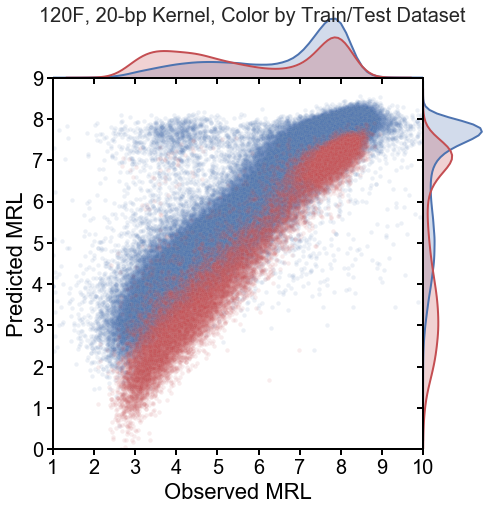

In [36]:
# Visualize Model performance on Test vs Train Datasets
train_test_plot = jointgrid_plot([e_train,e_test],yheader='20bp_pred',
                                 title='120F, 20-bp Kernel, Color by Train/Test Dataset')
print "Train is blue, Test is red"

KeyError: '10f20bp_pred'

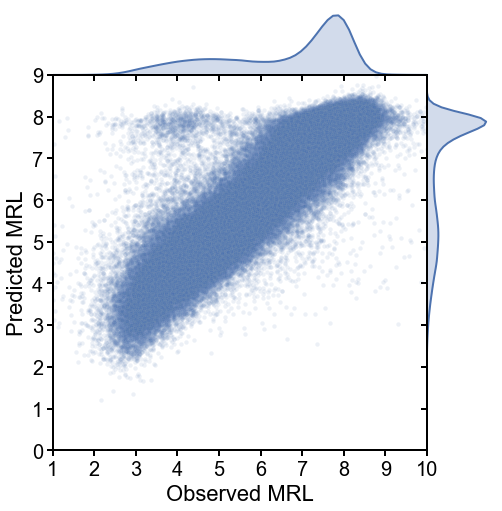

In [27]:
train_test_plot = jointgrid_plot([e_train,e_test],yheader='10f20bp_pred',
                                 title='10F, 20-bp Kernel, Color by Train/Test Dataset')

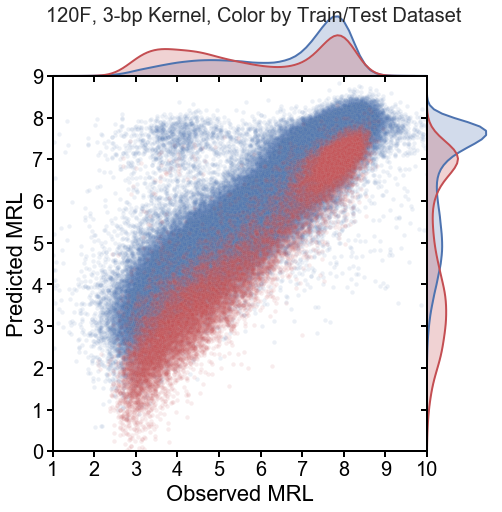

In [25]:
train_test_plot = jointgrid_plot([e_train,e_test],yheader='3bp_pred',
                                 title='120F, 3-bp Kernel, Color by Train/Test Dataset')

## Are the Off-Diagonal Sequences the Same?

(As compared to the authors' model, that is)

In [48]:
e_test['scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_test['rl'].values.reshape(-1,1))
e_test['dataset_name'] = ['test'] * len(e_test)
e_train['dataset_name'] = ['train'] * len(e_train)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [49]:
data = pd.concat([e_test,e_train])
data.head(4)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,0,1,10,10f16bp_pred,10f20bp_pred,10f25bp_pred,10f35bp_pred,10f50bp_pred,11,12,...,r5,r6,r7,r8,r9,rl,scaled_rl,total,total_reads,utr
0,0.000137,0.000109,0.000015,2.197207,1.958425,1.874129,1.835549,2.260955,0.000015,0.000013,...,0.033645,0.020343,0.019850,0.017988,0.019283,3.039939,-1.450869,0.000463,12126.0,CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCGGCTA
1,0.000067,0.000070,0.000016,3.159511,3.187447,2.714104,2.469670,2.468402,0.000016,0.000016,...,0.049711,0.028540,0.027431,0.024766,0.024241,3.895109,-0.987055,0.000395,10368.0,CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTATAGT
2,0.000088,0.000081,0.000011,2.090471,2.214345,1.885561,2.213697,1.991795,0.000011,0.000011,...,0.042436,0.022460,0.025015,0.024275,0.021591,3.334524,-1.291096,0.000379,9963.0,GTTATACTAGAAGAAACTTGAGATTATGGAGCAGTCCGTCAAGGACGCGA
3,0.000078,0.000071,0.000014,2.944825,2.851286,2.553872,2.305197,2.747138,0.000014,0.000012,...,0.041241,0.025793,0.022751,0.022632,0.026617,3.575082,-1.160626,0.000378,9934.0,CTTAGACAAAAACAACGCGCTTTCCAGTATGCGGAGCCTTGACGGTAAAC


In [65]:
od_16bp = data[((data['16bp_pred']-data['rl'])**2 > 3.5)&
                      (data['16bp_pred']-data['rl'] > 0)&
                      (data['16bp_pred'] > 6.5)]
od_20bp = data[((data['20bp_pred']-data['rl'])**2 > 3.5)&
                      (data['20bp_pred']-data['rl'] > 0)&
                      (data['20bp_pred'] > 6.5)]
od_21bp = data[((data['21bp_pred']-data['rl'])**2 > 3.5)&
                      (data['21bp_pred']-data['rl'] > 0)&
                      (data['21bp_pred'] > 6.5)]
od_small_16bp = data[((data['10f16bp_pred']-data['rl'])**2 > 3.5)&
                      (data['10f16bp_pred']-data['rl'] > 0)&
                      (data['10f16bp_pred'] > 6.5)]
od_small_20bp = data[((data['10f20bp_pred']-data['rl'])**2 > 3.5)&
                      (data['10f20bp_pred']-data['rl'] > 0)&
                      (data['10f20bp_pred'] > 6.5)]
od_small_25bp = data[((data['10f25bp_pred']-data['rl'])**2 > 3.5)&
                      (data['10f25bp_pred']-data['rl'] > 0)&
                      (data['10f25bp_pred'] > 6.5)]
od_small_35bp = data[((data['10f35bp_pred']-data['rl'])**2 > 3.5)&
                      (data['10f35bp_pred']-data['rl'] > 0)&
                      (data['10f35bp_pred'] > 6.5)]
od_small_50bp = data[((data['10f50bp_pred']-data['rl'])**2 > 3.5)&
                      (data['10f50bp_pred']-data['rl'] > 0)&
                      (data['10f50bp_pred'] > 6.5)]
print "120 filters 16bp Off-Diagonals","\t", len(od_16bp)
print "120 filters 20bp Off-Diagonals","\t", len(od_20bp)
print "120 filters 21bp Off-Diagonals","\t", len(od_21bp)
print "10 filters 16bp Off-Diagonals","\t", len(od_small_16bp)
print "10 filters 20bp Off-Diagonals","\t", len(od_small_20bp)
print "10 filters 25bp Off-Diagonals","\t", len(od_small_25bp)
print "10 filters 35bp Off-Diagonals","\t", len(od_small_35bp)
print "10 filters 50bp Off-Diagonals","\t", len(od_small_50bp)

120 filters 16bp Off-Diagonals 	1321
120 filters 20bp Off-Diagonals 	1279
120 filters 21bp Off-Diagonals 	1323
10 filters 16bp Off-Diagonals 	1693
10 filters 20bp Off-Diagonals 	1588
10 filters 25bp Off-Diagonals 	1463
10 filters 35bp Off-Diagonals 	1410
10 filters 50bp Off-Diagonals 	1592


In [ ]:
set16 = set(od_16bp['utr'].values)
set16small = set(od_small_16bp['utr'].values)
set20 = set(od_20bp['utr'].values)
set20small =set(od_small_20bp['utr'].values)

print "16 bp models, shared ODs:", len(set16.intersection(set16small)), "out of", len(set16small),len(set16)
print "20 bp models, shared ODs:", len(set20.intersection(set20small)), "out of", len(set20small),len(set20)
print "large models, shared ODs:", len(set16.intersection(set20)), "out of", len(set16),len(set20)
print "small models, shared ODs:", len(set16small.intersection(set20small)), "out of", len(set16small),len(set20small)

It seems like most of the off-diagonals are shared; there is consistently only around 30-150 sequence (10% or less) that are not shared in any of these comparisons

In [67]:
large_superset = set16.intersection(set20.intersection(set(od_21bp['utr'].values)))
small_superset = set16small.intersection(set20small.intersection(
                                         set(od_small_25bp['utr'].values).intersection(
                                         set(od_small_35bp['utr'].values).intersection(
                                         set(od_small_50bp['utr'].values)))))
print len(large_superset), len(small_superset)
od_superset = large_superset.intersection(small_superset)
print len(od_superset)

1210 1278
1166


In [68]:
# # Save Off-Diagonal Data
# data[data['utr'].isin(set16)].to_csv("./saved_data/off_diagonal_cluster/CNN_120f16bp_total_od.csv")
# data[data['utr'].isin(set20)].to_csv("./saved_data/off_diagonal_cluster/CNN_120f20bp_total_od.csv")
# data[data['utr'].isin(od_21bp['utr'].values)].to_csv("./saved_data/off_diagonal_cluster/CNN_120f21bp_total_od.csv")
# data[data['utr'].isin(set16small)].to_csv("./saved_data/off_diagonal_cluster/CNN_10f16bp_total_od.csv")
# data[data['utr'].isin(set20small)].to_csv("./saved_data/off_diagonal_cluster/CNN_10f20bp_total_od.csv")                      
# data[data['utr'].isin(od_small_50bp['utr'].values)].to_csv("./saved_data/off_diagonal_cluster/CNN_10f50bp_total_od.csv")                      
# data[data['utr'].isin(od_superset)].to_csv("./saved_data/off_diagonal_cluster/CNN_LongRangeIntersection_total_od.csv")
# data[data['utr'].isin(large_superset)].to_csv("./saved_data/off_diagonal_cluster/CNN_120f16to21bp_total_od.csv")
# data[data['utr'].isin(small_superset)].to_csv("./saved_data/off_diagonal_cluster/CNN_10f16to50bp_total_od.csv")

### Extra Question: How well do these models correlate with each other?

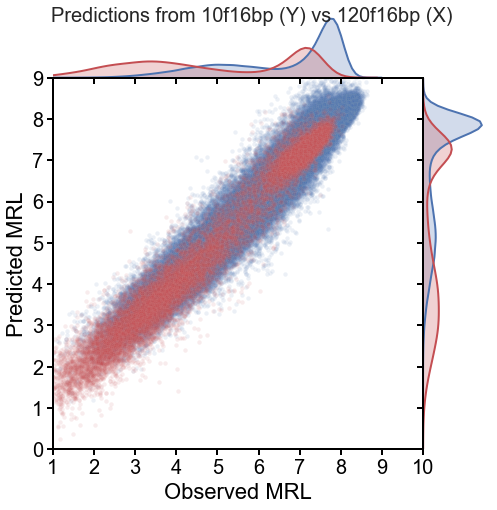

In [60]:
comp1 = jointgrid_plot([e_train,e_test],yheader='10f16bp_pred',xheader='16bp_pred',
                                 title='Predictions from 10f16bp (Y) vs 120f16bp (X)')

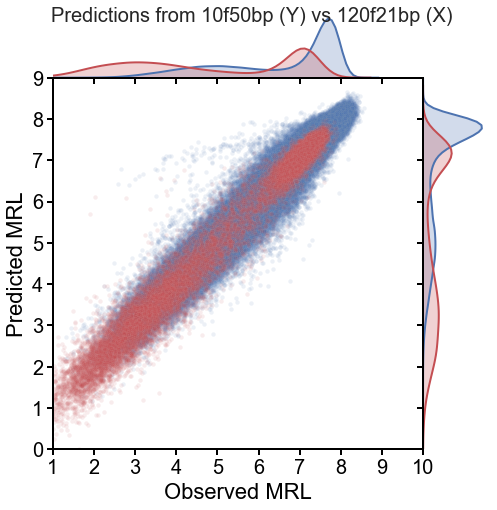

In [63]:
comp2 = jointgrid_plot([e_train,e_test],yheader='10f50bp_pred',xheader='20bp_pred',
                                 title='Predictions from 10f50bp (Y) vs 120f21bp (X)')

Looks like they correlate pretty well overall. I wonder what that spur of train set points is in the lower graph?

# Try to Optimize Model Parameters

Small kernel size, more layers, more epochs. Try with validation set, even?

In [11]:
# The training set has 240k UTRs, the validation set has 10k, and the test set has 20k UTRs.
test = df.iloc[:20000]
valid = df.iloc[20000:30000]
train = df.iloc[30000:]

# One-hot encode both training and test UTRs
seq_train = one_hot_encode(train,seq_len=50)
seq_valid = one_hot_encode(valid,seq_len=50)
seq_test = one_hot_encode(test, seq_len=50)

label_train = train['rl'].values
label_valid = valid['rl'].values
label_test = valid['rl'].values

# Scale the training mean ribosome load values
# LAE: added .values before reshape due to pandas naming deprecation
train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(train.loc[:,'rl'].values.reshape(-1,1))
valid.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(valid.loc[:,'rl'].values.reshape(-1,1))
test.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(test.loc[:,'rl'].values.reshape(-1,1))

In [43]:
np.random.seed(1337)
model = Sequential()
model.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=60, kernel_size=3))
model.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=120, kernel_size=6))
model.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=120, kernel_size=6))
model.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=60, kernel_size=6))
model.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=20, kernel_size=6))

model.add(Flatten())
model.add(Dense(40))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('linear'))

#compile the model
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='mean_squared_error', optimizer=adam)

In [44]:
model.fit(seq_train, label_train, batch_size=128, epochs=3, verbose=1)
valid = test_data(valid,model,obs_col='rl',test_seq=seq_valid,output_col='3e_pred')
r = r2(valid['rl'], valid['3e_pred'])
print 'validation r-squared = ', r 

Epoch 1/3
250000/250000 [==============================] - 149s 598us/step - loss: 2.0194
Epoch 2/3
250000/250000 [==============================] - 141s 566us/step - loss: 1.1243
Epoch 3/3
250000/250000 [==============================] - 146s 584us/step - loss: 0.9247
validation r-squared =  0.8775896466079974


In [45]:
model.fit(seq_train, label_train, batch_size=128, epochs=3, verbose=1)
valid = test_data(valid,model,obs_col='rl',test_seq=seq_valid,output_col='6e_pred')
r = r2(valid['rl'], valid['6e_pred'])
print 'validation r-squared = ', r 

Epoch 1/3
250000/250000 [==============================] - 123s 493us/step - loss: 0.7607
Epoch 2/3
250000/250000 [==============================] - 133s 532us/step - loss: 0.6252
Epoch 3/3
250000/250000 [==============================] - 117s 469us/step - loss: 0.5466
validation r-squared =  0.9042796509996747


In [46]:
model.fit(seq_train, label_train, batch_size=128, epochs=3, verbose=1)
valid = test_data(valid,model,obs_col='rl',test_seq=seq_valid,output_col='9e_pred')
r = r2(valid['rl'], valid['9e_pred'])
print 'validation r-squared = ', r 

Epoch 1/3
250000/250000 [==============================] - 123s 491us/step - loss: 0.5113
Epoch 2/3
250000/250000 [==============================] - 125s 499us/step - loss: 0.4752
Epoch 3/3
250000/250000 [==============================] - 137s 548us/step - loss: 0.4374
validation r-squared =  0.9207130122395936


In [47]:
model.fit(seq_train, label_train, batch_size=128, epochs=3, verbose=1)
valid = test_data(valid,model,obs_col='rl',test_seq=seq_valid,output_col='12e_pred')
r = r2(valid['rl'], valid['12e_pred'])
print 'validation r-squared = ', r 

Epoch 1/3
250000/250000 [==============================] - 132s 529us/step - loss: 0.4288
Epoch 2/3
250000/250000 [==============================] - 138s 553us/step - loss: 0.4135
Epoch 3/3
250000/250000 [==============================] - 138s 552us/step - loss: 0.3993
validation r-squared =  0.9248151619815304


In [48]:
test = test_data(test,model,obs_col='rl',test_seq=seq_test,output_col='12e_pred')
r = r2(test['rl'], test['12e_pred'])
print 'test r-squared = ', r 

test r-squared =  0.9298384522919382


In [49]:
model.fit(seq_train, label_train, batch_size=128, epochs=3, verbose=1)
valid = test_data(valid,model,obs_col='rl',test_seq=seq_valid,output_col='15e_pred')
r = r2(valid['rl'], valid['15e_pred'])
print 'validation r-squared = ', r 

Epoch 1/3
250000/250000 [==============================] - 141s 564us/step - loss: 0.3846
Epoch 2/3
250000/250000 [==============================] - 135s 540us/step - loss: 0.3735
Epoch 3/3
250000/250000 [==============================] - 139s 558us/step - loss: 0.3622
validation r-squared =  0.9274575907564232


In [50]:
test = test_data(test,model,obs_col='rl',test_seq=seq_test,output_col='15e_pred')
r = r2(test['rl'], test['15e_pred'])
print 'test r-squared = ', r 

test r-squared =  0.9324767778470084


In [51]:
model.fit(seq_train, label_train, batch_size=128, epochs=3, verbose=1)
valid = test_data(valid,model,obs_col='rl',test_seq=seq_valid,output_col='18e_pred')
r = r2(valid['rl'], valid['18e_pred'])
print 'validation r-squared = ', r 

Epoch 1/3
250000/250000 [==============================] - 135s 538us/step - loss: 0.3576
Epoch 2/3
250000/250000 [==============================] - 122s 489us/step - loss: 0.3527
Epoch 3/3
250000/250000 [==============================] - 114s 455us/step - loss: 0.3512
validation r-squared =  0.9237292253530971


In [52]:
test = test_data(test,model,obs_col='rl',test_seq=seq_test,output_col='18e_pred')
r = r2(test['rl'], test['18e_pred'])
print 'test r-squared = ', r 

test r-squared =  0.9297331737967521


In [12]:
np.random.seed(1337)
model2 = Sequential()

model2.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=60, kernel_size=3))
model2.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=60, kernel_size=3))
model2.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=30, kernel_size=3))
model2.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=30, kernel_size=3))
model2.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=20, kernel_size=3))
model2.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=20, kernel_size=3))
model2.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=20, kernel_size=3))
model2.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=20, kernel_size=3))

model2.add(Flatten())
model2.add(Dense(40))
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1))
model2.add(Activation('linear'))

#compile the model
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model2.compile(loss='mean_squared_error', optimizer=adam)

In [13]:
model2.fit(seq_train, label_train, batch_size=128, epochs=3, verbose=1)
valid = test_data(valid,model2,obs_col='rl',test_seq=seq_valid,output_col='3e_pred2')
r = r2(valid['rl'], valid['3e_pred2'])
print 'validation r-squared = ', r 

Epoch 1/3
250000/250000 [==============================] - 56s 224us/step - loss: 1.9137
Epoch 2/3
250000/250000 [==============================] - 52s 209us/step - loss: 1.2483
Epoch 3/3
250000/250000 [==============================] - 56s 222us/step - loss: 1.0376
validation r-squared =  0.8496387695847546


In [14]:
model2.fit(seq_train, label_train, batch_size=128, epochs=3, verbose=1)
valid = test_data(valid,model2,obs_col='rl',test_seq=seq_valid,output_col='6e_pred2')
r = r2(valid['rl'], valid['6e_pred2'])
print 'validation r-squared = ', r 

Epoch 1/3
250000/250000 [==============================] - 53s 210us/step - loss: 0.8578
Epoch 2/3
250000/250000 [==============================] - 53s 213us/step - loss: 0.7136
Epoch 3/3
250000/250000 [==============================] - 57s 229us/step - loss: 0.6134
validation r-squared =  0.8832464986139691


In [15]:
model2.fit(seq_train, label_train, batch_size=128, epochs=3, verbose=1)
valid = test_data(valid,model2,obs_col='rl',test_seq=seq_valid,output_col='9e_pred2')
r = r2(valid['rl'], valid['9e_pred2'])
print 'validation r-squared = ', r 

Epoch 1/3
250000/250000 [==============================] - 53s 213us/step - loss: 0.5324
Epoch 2/3
250000/250000 [==============================] - 59s 235us/step - loss: 0.4917
Epoch 3/3
250000/250000 [==============================] - 56s 225us/step - loss: 0.4597
validation r-squared =  0.9138622466948083


In [16]:
model2.fit(seq_train, label_train, batch_size=128, epochs=3, verbose=1)
valid = test_data(valid,model2,obs_col='rl',test_seq=seq_valid,output_col='11e_pred2')
r = r2(valid['rl'], valid['11e_pred2'])
print 'validation r-squared = ', r 

Epoch 1/3
250000/250000 [==============================] - 52s 210us/step - loss: 0.4447
Epoch 2/3
250000/250000 [==============================] - 53s 211us/step - loss: 0.4340
Epoch 3/3
250000/250000 [==============================] - 57s 226us/step - loss: 0.4258
validation r-squared =  0.9170334277563709


In [17]:
np.random.seed(1337)
model3 = Sequential()

model3.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=30, kernel_size=3))
model3.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=90, kernel_size=7))
model3.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=60, kernel_size=3))
model3.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=30, kernel_size=3))
model3.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=30, kernel_size=3))


model3.add(Flatten())
model3.add(Dense(40))
model3.add(Activation('relu'))
model3.add(Dropout(0.1))
model3.add(Dense(1))
model3.add(Activation('linear'))

#compile the model
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model3.compile(loss='mean_squared_error', optimizer=adam)

In [18]:
model3.fit(seq_train, label_train, batch_size=128, epochs=3, verbose=1)
valid = test_data(valid,model3,obs_col='rl',test_seq=seq_valid,output_col='3e_pred3')
r = r2(valid['rl'], valid['3e_pred3'])
print 'validation r-squared = ', r 

Epoch 1/3
250000/250000 [==============================] - 61s 243us/step - loss: 1.4575
Epoch 2/3
250000/250000 [==============================] - 58s 232us/step - loss: 0.8022
Epoch 3/3
250000/250000 [==============================] - 56s 225us/step - loss: 0.7018
validation r-squared =  0.8807583937741714


In [19]:
model3.fit(seq_train, label_train, batch_size=128, epochs=3, verbose=1)
valid = test_data(valid,model3,obs_col='rl',test_seq=seq_valid,output_col='3e_pred3')
r = r2(valid['rl'], valid['3e_pred3'])
print 'validation r-squared = ', r 

Epoch 1/3
250000/250000 [==============================] - 62s 247us/step - loss: 0.6224
Epoch 2/3
250000/250000 [==============================] - 61s 246us/step - loss: 0.5502
Epoch 3/3
250000/250000 [==============================] - 59s 234us/step - loss: 0.4979
validation r-squared =  0.9142185940845052


In [20]:
model3.fit(seq_train, label_train, batch_size=128, epochs=3, verbose=1)
valid = test_data(valid,model3,obs_col='rl',test_seq=seq_valid,output_col='6e_pred3')
r = r2(valid['rl'], valid['6e_pred3'])
print 'validation r-squared = ', r 


Epoch 1/3
250000/250000 [==============================] - 62s 247us/step - loss: 0.4619
Epoch 2/3
250000/250000 [==============================] - 56s 224us/step - loss: 0.4319
Epoch 3/3
250000/250000 [==============================] - 64s 256us/step - loss: 0.4085
validation r-squared =  0.9222910310272016


In [21]:
model3.fit(seq_train, label_train, batch_size=128, epochs=3, verbose=1)
valid = test_data(valid,model3,obs_col='rl',test_seq=seq_valid,output_col='9e_pred3')
r = r2(valid['rl'], valid['9e_pred3'])
print 'validation r-squared = ', r 

Epoch 1/3
250000/250000 [==============================] - 64s 256us/step - loss: 0.3886
Epoch 2/3
250000/250000 [==============================] - 66s 264us/step - loss: 0.3721
Epoch 3/3
250000/250000 [==============================] - 55s 219us/step - loss: 0.3604
validation r-squared =  0.9246252514363892


In [22]:
model3.fit(seq_train, label_train, batch_size=128, epochs=3, verbose=1)
valid = test_data(valid,model3,obs_col='rl',test_seq=seq_valid,output_col='12e_pred3')
r = r2(valid['rl'], valid['12e_pred3'])
print 'validation r-squared = ', r 

Epoch 1/3
250000/250000 [==============================] - 66s 265us/step - loss: 0.3518
Epoch 2/3
250000/250000 [==============================] - 60s 242us/step - loss: 0.3432
Epoch 3/3
250000/250000 [==============================] - 82s 328us/step - loss: 0.3372
validation r-squared =  0.925321532349394


In [23]:
model3.fit(seq_train, label_train, batch_size=128, epochs=3, verbose=1)
valid = test_data(valid,model3,obs_col='rl',test_seq=seq_valid,output_col='15e_pred3')
r = r2(valid['rl'], valid['15e_pred3'])
print 'validation r-squared = ', r 

Epoch 1/3
250000/250000 [==============================] - 70s 280us/step - loss: 0.3307
Epoch 2/3
250000/250000 [==============================] - 65s 261us/step - loss: 0.3274
Epoch 3/3
250000/250000 [==============================] - 59s 235us/step - loss: 0.3242
validation r-squared =  0.9242078823027533


In [24]:
test = test_data(test,model3,obs_col='rl',test_seq=seq_test,output_col='15e_pred3')
r = r2(test['rl'], test['15e_pred3'])
print 'test r-squared = ', r 

test r-squared =  0.929648093163141


In [41]:
np.random.seed(1337)
model4 = Sequential()

model4.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=30, kernel_size=3))
model4.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=60, kernel_size=7))
model4.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=30, kernel_size=7))
model4.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=30, kernel_size=3))
model4.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=20, kernel_size=3))
model4.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=20, kernel_size=3))
model4.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=20, kernel_size=3))
model4.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=20, kernel_size=3))
model4.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=20, kernel_size=3))
model4.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=20, kernel_size=3))


model4.add(Flatten())
model4.add(Dense(40))
model4.add(Activation('relu'))
model4.add(Dropout(0.1))
model4.add(Dense(1))
model4.add(Activation('linear'))

#compile the model
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model4.compile(loss='mean_squared_error', optimizer=adam)

In [42]:
model4.fit(seq_train, label_train, batch_size=128, epochs=3, verbose=1)
valid = test_data(valid,model4,obs_col='rl',test_seq=seq_valid,output_col='3e_pred4')
r = r2(valid['rl'], valid['3e_pred4'])
print 'validation r-squared = ', r 

Epoch 1/3
250000/250000 [==============================] - 86s 344us/step - loss: 1.7507
Epoch 2/3
250000/250000 [==============================] - 81s 324us/step - loss: 0.8547
Epoch 3/3
250000/250000 [==============================] - 80s 322us/step - loss: 0.7452
validation r-squared =  0.8618311091294882


In [43]:
model4.fit(seq_train, label_train, batch_size=128, epochs=3, verbose=1)
valid = test_data(valid,model4,obs_col='rl',test_seq=seq_valid,output_col='6e_pred4')
r = r2(valid['rl'], valid['6e_pred4'])
print 'validation r-squared = ', r 

Epoch 1/3
250000/250000 [==============================] - 94s 377us/step - loss: 0.6522
Epoch 2/3
250000/250000 [==============================] - 82s 326us/step - loss: 0.5905
Epoch 3/3
250000/250000 [==============================] - 81s 325us/step - loss: 0.5393
validation r-squared =  0.8990043927828876


In [44]:
model4.fit(seq_train, label_train, batch_size=128, epochs=3, verbose=1)
valid = test_data(valid,model4,obs_col='rl',test_seq=seq_valid,output_col='9e_pred4')
r = r2(valid['rl'], valid['9e_pred4'])
print 'validation r-squared = ', r 

Epoch 1/3
250000/250000 [==============================] - 82s 328us/step - loss: 0.4951
Epoch 2/3
250000/250000 [==============================] - 84s 335us/step - loss: 0.4498
Epoch 3/3
250000/250000 [==============================] - 81s 325us/step - loss: 0.4062
validation r-squared =  0.9254460620528955


In [45]:
model4.fit(seq_train, label_train, batch_size=128, epochs=3, verbose=1)
valid = test_data(valid,model4,obs_col='rl',test_seq=seq_valid,output_col='12e_pred4')
r = r2(valid['rl'], valid['12e_pred4'])
print 'validation r-squared = ', r 

Epoch 1/3
250000/250000 [==============================] - 90s 360us/step - loss: 0.3789
Epoch 2/3
250000/250000 [==============================] - 81s 326us/step - loss: 0.3591
Epoch 3/3
250000/250000 [==============================] - 83s 334us/step - loss: 0.3464
validation r-squared =  0.9288011322573485


In [46]:
model4.fit(seq_train, label_train, batch_size=128, epochs=3, verbose=1)
valid = test_data(valid,model4,obs_col='rl',test_seq=seq_valid,output_col='15e_pred4')
r = r2(valid['rl'], valid['15e_pred4'])
print 'validation r-squared = ', r 

Epoch 1/3
250000/250000 [==============================] - 86s 343us/step - loss: 0.3357
Epoch 2/3
250000/250000 [==============================] - 102s 409us/step - loss: 0.3302
Epoch 3/3
250000/250000 [==============================] - 91s 365us/step - loss: 0.3236
validation r-squared =  0.9328551928297442


In [47]:
test = test_data(test,model4,obs_col='rl',test_seq=seq_test,output_col='15e_pred4')
r = r2(test['rl'], test['15e_pred4'])
print 'test r-squared = ', r 

test r-squared =  0.9380285616144659


In [32]:
np.random.seed(1337)
model5 = Sequential()

model5.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=30, kernel_size=3))
model5.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=60, kernel_size=7))
model5.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=30, kernel_size=7))
model5.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=30, kernel_size=3))
model5.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=20, kernel_size=3))
model5.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=20, kernel_size=3))
model5.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=20, kernel_size=3))
model5.add(Conv1D(activation="relu", input_shape=(50, 4),
                 padding="same", filters=20, kernel_size=3))


model5.add(Flatten())
model5.add(Dense(40))
model5.add(Activation('relu'))
model5.add(Dropout(0.1))
model5.add(Dense(1))
model5.add(Activation('linear'))

#compile the model
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model5.compile(loss='mean_squared_error', optimizer=adam)

In [33]:
model5.fit(seq_train, label_train, batch_size=128, epochs=3, verbose=1)
valid = test_data(valid,model5,obs_col='rl',test_seq=seq_valid,output_col='3e_pred5')
r = r2(valid['rl'], valid['3e_pred5'])
print 'validation r-squared = ', r 

Epoch 1/3
250000/250000 [==============================] - 76s 302us/step - loss: 1.5443
Epoch 2/3
250000/250000 [==============================] - 74s 294us/step - loss: 0.7427
Epoch 3/3
250000/250000 [==============================] - 73s 292us/step - loss: 0.6635
validation r-squared =  0.8819408863338086


In [34]:
model5.fit(seq_train, label_train, batch_size=128, epochs=3, verbose=1)
valid = test_data(valid,model5,obs_col='rl',test_seq=seq_valid,output_col='6e_pred5')
r = r2(valid['rl'], valid['6e_pred5'])
print 'validation r-squared = ', r 

Epoch 1/3
250000/250000 [==============================] - 74s 297us/step - loss: 0.5901
Epoch 2/3
250000/250000 [==============================] - 74s 297us/step - loss: 0.5482
Epoch 3/3
250000/250000 [==============================] - 74s 294us/step - loss: 0.5057
validation r-squared =  0.9132179217189538


In [35]:
model5.fit(seq_train, label_train, batch_size=128, epochs=3, verbose=1)
valid = test_data(valid,model5,obs_col='rl',test_seq=seq_valid,output_col='9e_pred5')
r = r2(valid['rl'], valid['9e_pred5'])
print 'validation r-squared = ', r 

Epoch 1/3
250000/250000 [==============================] - 74s 297us/step - loss: 0.4498
Epoch 2/3
250000/250000 [==============================] - 74s 294us/step - loss: 0.4182
Epoch 3/3
250000/250000 [==============================] - 74s 296us/step - loss: 0.3934
validation r-squared =  0.9275723344213682


In [36]:
model5.fit(seq_train, label_train, batch_size=128, epochs=3, verbose=1)
valid = test_data(valid,model5,obs_col='rl',test_seq=seq_valid,output_col='12e_pred5')
r = r2(valid['rl'], valid['12e_pred5'])
print 'validation r-squared = ', r 

Epoch 1/3
250000/250000 [==============================] - 73s 293us/step - loss: 0.3747
Epoch 2/3
250000/250000 [==============================] - 73s 292us/step - loss: 0.3605
Epoch 3/3
250000/250000 [==============================] - 73s 294us/step - loss: 0.3464
validation r-squared =  0.9297221337629481


In [37]:
model5.fit(seq_train, label_train, batch_size=128, epochs=3, verbose=1)
valid = test_data(valid,model5,obs_col='rl',test_seq=seq_valid,output_col='15e_pred5')
r = r2(valid['rl'], valid['15e_pred5'])
print 'validation r-squared = ', r 

Epoch 1/3
250000/250000 [==============================] - 74s 295us/step - loss: 0.3372
Epoch 2/3
250000/250000 [==============================] - 73s 293us/step - loss: 0.3292
Epoch 3/3
250000/250000 [==============================] - 73s 292us/step - loss: 0.3220
validation r-squared =  0.9318939666700411


In [38]:
model5.fit(seq_train, label_train, batch_size=128, epochs=3, verbose=1)
valid = test_data(valid,model5,obs_col='rl',test_seq=seq_valid,output_col='18e_pred5')
r = r2(valid['rl'], valid['18e_pred5'])
print 'validation r-squared = ', r 

Epoch 1/3
250000/250000 [==============================] - 74s 295us/step - loss: 0.3157
Epoch 2/3
250000/250000 [==============================] - 73s 293us/step - loss: 0.3092
Epoch 3/3
250000/250000 [==============================] - 75s 301us/step - loss: 0.3054
validation r-squared =  0.9303013705966712


In [ ]:
test = test_data(test,model5,obs_col='rl',test_seq=seq_test,output_col='18e_pred5')
r = r2(test['rl'], test['18e_pred5'])
print 'test r-squared = ', r 

In [ ]:
train = test_data(train, model=model5, obs_col='rl', test_seq=seq_train,output_col='18e_pred5')
r = r2(train['rl'], train['18e_pred'])
print 'train r-squared = ', r

In [ ]:
pred5 = jointgrid_plot([train,test],yheader='18e_pred5',xheader='rl',
                                 title='Predictions from 8-layer Model, Mostly 3bp kernels')